In [88]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import warnings
from nltk import word_tokenize, pos_tag, FreqDist, SnowballStemmer
from nltk.corpus import wordnet as wn, stopwords
from gensim import corpora, models
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline
from wordcloud import WordCloud
from nltk.util import ngrams

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [3]:
userComments1 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (0-100k).csv')
userComments2 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (100-200k).csv')
userComments3 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (200-300k).csv')

userComments3['Unnamed: 0'] = userComments3['Unnamed: 0'].astype('float64')
userComments3['Userscore'] = userComments3['Userscore'].astype('float64')

userComments = pd.concat([userComments1, userComments2, userComments3], axis = 0)
userComments.drop(columns = 'Unnamed: 0', inplace = True)
userComments.dropna(how = 'all', inplace = True)

userComments.Platform.unique()

platformMap = {
'Nintendo64': 'Nintendo',
'GameBoyAdvance': 'Nintendo',
'3DS': 'Nintendo',
'DS': 'Nintendo',
'Wii': 'Nintendo',
'Switch': 'Nintendo',
'WiiU': 'Nintendo',
'GameCube': 'Nintendo',
'PlayStation': 'PlayStation',
'PlayStation3': 'PlayStation',
'PlayStation2': 'PlayStation',
'PlayStation4': 'PlayStation',
'PlayStationVita': 'PlayStation',
'PSP': 'PlayStation',
'Xbox360': 'Xbox',
'Xbox': 'Xbox',
'XboxOne': 'Xbox',
'PC': 'PC',
'Dreamcast': 'Others',
'not specified': 'Others'
}

userComments['platformCondensed'] = userComments.Platform.map(platformMap)

In [4]:
# TO REMOVE EVENTUALLY!!
userComments = userComments.sample(500).copy()

In [181]:
filter_list = ["would", "could", "left", "right", "a.m.", "p.m.", "'s", "...", ":", ";", "n't", "game", "games", "play", "fun", "much", "one", "great"]

def preprocess_text(tokens, needtokenizeBoolean = True, grams = False,  ngramsNummber = 2, furtherPreProcessNgrams = False):
    if needtokenizeBoolean:
        tokens = nltk.word_tokenize(tokens)
        if grams:
            tokens = list(ngrams(tokens, ngramsNummber))
    if grams:
        tokens = [' '.join(gram) for gram in tokens]
        if furtherPreProcessNgrams == False:
            return tokens
            
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stopwords.words('english') + filter_list]
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if not t.isnumeric()]
    snowball = SnowballStemmer('english')
    tokens = [snowball.stem(t) for t in tokens]
    
    return tokens

def wc(df, columnName, preProcessingFunctionBoolean = True, tfidfVectorizerBoolean = True,
       nounTaggingBoolean = False, universalNounTagsetBoolean = False, ngrams = False, ngramsNummber = 2, furtherPreProcessNgrams = False,
       top = 10, features_improvements = 'Word Cloud', platform = 'All'):

    if preProcessingFunctionBoolean == True & ngrams == True:
        if tfidfVectorizerBoolean == True:
            if furtherPreProcessNgrams == True:
                tdm = TfidfVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber, furtherPreProcessNgrams = True), min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
            else:
                tdm = TfidfVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber), min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
        else:
            if furtherPreProcessNgrams == True:
                tdm = CountVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber, furtherPreProcessNgrams = True), min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
            else:
                tdm = CountVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber), min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
        tdmMatrix = tdm.fit_transform(df[columnName])
    
    if nounTaggingBoolean == True and ngrams == False:
        noun_list = []
        for value in df[columnName]:
            if universalNounTagsetBoolean == True:
                tagged_value = pos_tag(word_tokenize(value), tagset='universal')
                noun = [word for word, tag in tagged_value if tag == 'NOUN']
            else:
                tagged_value = pos_tag(word_tokenize(value))
                noun = [word for word, tag in tagged_value if tag == 'NN' or tag == 'NNS']
            noun_list.append(noun)
        df['Text_NounOnly'] = noun_list
        if preProcessingFunctionBoolean == True:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: preprocess_text(tokens = x, needtokenizeBoolean=False))
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        else:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        if tfidfVectorizerBoolean == True:
            tdm = TfidfVectorizer(min_df = 2, max_df=0.7) # min_df = 2, max_df=0.7
        else:
            tdm = CountVectorizer(min_df = 2, max_df=0.7) # min_df = 2, max_df=0.7
        tdmMatrix = tdm.fit_transform(df['Text_NounOnly'])
    if nounTaggingBoolean != True and ngrams == False:
        if tfidfVectorizerBoolean == True:
            if preProcessingFunctionBoolean == True:
                tdm = TfidfVectorizer(tokenizer = preprocess_text, min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
            else:
                tdm = TfidfVectorizer()
        else:
            if preProcessingFunctionBoolean == True:
                tdm = CountVectorizer(tokenizer = preprocess_text, min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
            else:
                tdm = CountVectorizer()
        tdmMatrix = tdm.fit_transform(df[columnName])

    array = tdmMatrix.toarray()
    feature_names = tdm.get_feature_names_out()
    word_tfidf = dict(zip(feature_names, array.sum(axis=0)))
    fd_tfidf= FreqDist(word_tfidf)
    wc = WordCloud(background_color="white").generate_from_frequencies(fd_tfidf)
    plt.figure()
    plt.suptitle(f"{features_improvements} ({platform})", fontsize = 20, x = 0.5, y = 0.85, fontweight = 'bold', fontname = 'Calibri') 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    displayList = []
    for x,y in fd_tfidf.most_common(top):
        displayList.append((x, round(y, 2)))

    plt.show()
    print(displayList)

In [18]:
userCommentsNotNull = userComments[userComments.Comment.notnull()]

userCommentsNotNull.loc[userCommentsNotNull.Userscore > 7, 'scoreBin'] = 'High'
userCommentsNotNull.loc[(userCommentsNotNull.Userscore >= 4) & (userCommentsNotNull.Userscore <= 7), 'scoreBin'] = 'Medium'
userCommentsNotNull.loc[userCommentsNotNull.Userscore < 4, 'scoreBin'] = 'Low'

userCommentsHigh = userCommentsNotNull[userCommentsNotNull.scoreBin == 'High']
userCommentsLow = userCommentsNotNull[userCommentsNotNull.scoreBin == 'Low']

print(f"High counts: {userCommentsHigh.shape[0]}\nLow counts: {userCommentsLow.shape[0]}")

High counts: 338
Low counts: 79


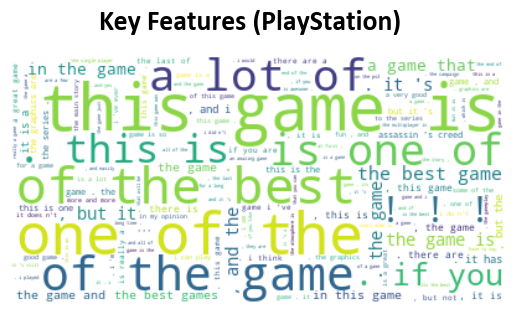

[('this game is', 32), ('one of the', 26), ('of the best', 19), ('of the game', 18), ('a lot of', 16), ('is one of', 16), ('. this is', 14), ('! ! !', 12), ('. if you', 12), ('the best game', 12)]


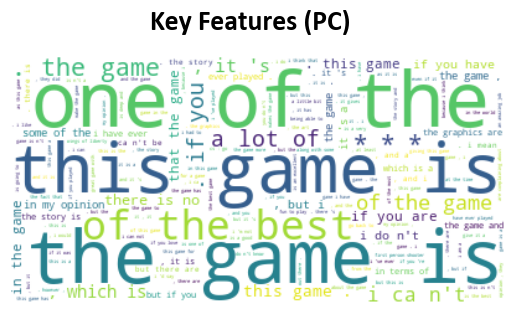

[('one of the', 23), ('the game is', 21), ('this game is', 20), ('of the best', 19), ('. the game', 17), ('* * *', 16), ('. if you', 15), ('a lot of', 15), ('of the game', 14), ("i ca n't", 13)]


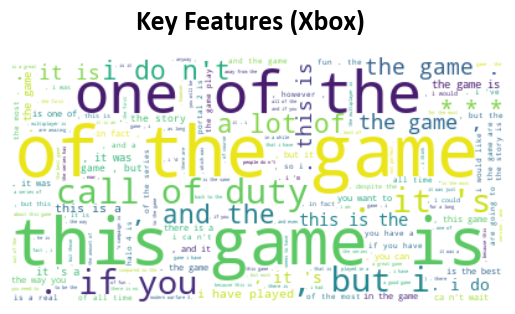

[('of the game', 22), ('this game is', 19), ('one of the', 15), ('call of duty', 14), (', but i', 13), ('. if you', 13), (". it 's", 13), (', and the', 12), ('a lot of', 12), ("i do n't", 12)]


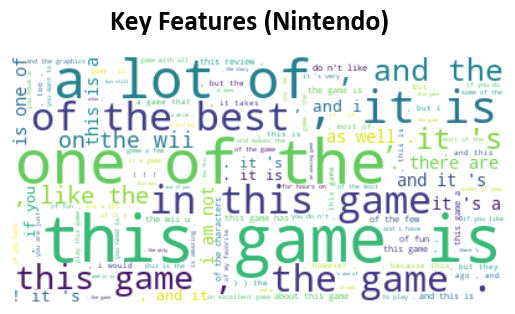

[('this game is', 14), ('one of the', 13), ('a lot of', 10), (', it is', 7), ('in this game', 7), ('of the best', 7), ('the game .', 7), ('this game ,', 7), (', and the', 6), (", it 's", 6)]


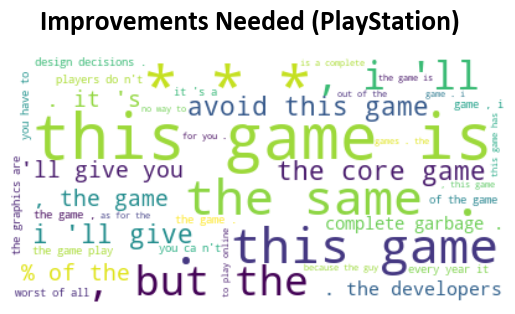

[('this game is', 8), ('* * *', 6), ('. this game', 5), ('the same .', 5), (', but the', 4), (", i 'll", 4), ('avoid this game', 4), ("i 'll give", 4), ('the core game', 4), ('% of the', 3)]


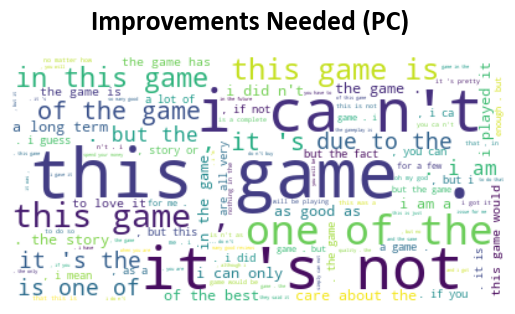

[('this game .', 11), ("i ca n't", 8), ("it 's not", 8), ('one of the', 8), ('this game ,', 8), ('this game is', 8), ('in this game', 7), (", it 's", 6), ('of the game', 6), ('due to the', 5)]


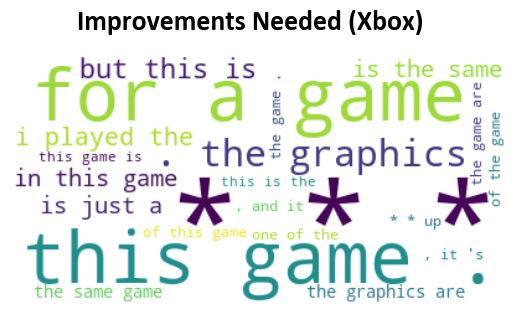

[('* * *', 12), ('for a game', 4), ('this game .', 4), ('. the graphics', 3), ('but this is', 3), ('i played the', 3), ('in this game', 3), ('is just a', 3), ('is the same', 3), ('the graphics are', 3)]


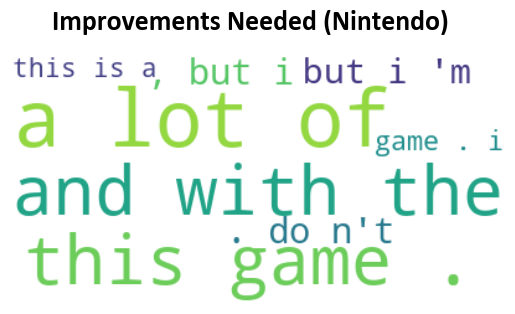

[('a lot of', 3), ('and with the', 3), ('this game .', 3), (', but i', 2), (". do n't", 2), ("but i 'm", 2), ('game . i', 2), ('this is a', 2)]
CPU times: total: 1.06 s
Wall time: 1.96 s


In [185]:
%%time

# if ngrams = True, preProcessingFunctionBoolean needs to be True 

userCommentsExtreme_list = [userCommentsHigh, userCommentsLow]
platformCondensed_list = list(userCommentsNotNull[userCommentsNotNull.scoreBin != 'Medium'].platformCondensed.unique())

for df in userCommentsExtreme_list:
    for platform in platformCondensed_list:
            if df.scoreBin.max() == 'High':
                features_improvements = 'Key Features'
            elif df.scoreBin.max() == 'Low':
                features_improvements = 'Improvements Needed'
            wc(df = df[df.platformCondensed == platform], columnName = 'Comment', preProcessingFunctionBoolean = True,
                    ngrams = True, ngramsNummber = 3, furtherPreProcessNgrams = False, tfidfVectorizerBoolean = False, top = 10,
                    nounTaggingBoolean = True, universalNounTagsetBoolean = False,
                    features_improvements = features_improvements, platform = platform)